In [4]:
import ezc3d
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

# 1. Load the C3D file
c3d_path = 'CVIP\\Project\\data\\C3D\\Calibration.c3d'  # Make sure this file is in your folder
c = ezc3d.c3d(c3d_path)

# Extract data
# points shape is (4, n_markers, n_frames). 4 components are (x, y, z, 1)
point_data = c['data']['points']
labels = c['parameters']['POINT']['LABELS']['value']

# Helper function to get (x, y, z) for a specific marker at a specific frame
def get_marker_pos(name, frame_idx):
    try:
        idx = labels.index(name)
        # return x, y, z
        return point_data[0:3, idx, frame_idx]
    except ValueError:
        return None

# 2. Define the Skeleton Structure (Bone Connections)
# This maps the marker names in your file to a stick-figure structure.
skeleton_bones = [
    # Head
    ('LFHD', 'RFHD'), ('RFHD', 'RBHD'), ('RBHD', 'LBHD'), ('LBHD', 'LFHD'),
    # Torso / Spine
    ('C7', 'T10'), ('C7', 'CLAV'), ('CLAV', 'STRN'), ('STRN', 'T10'),
    ('CLAV', 'LSHO'), ('CLAV', 'RSHO'),
    # Left Arm
    ('LSHO', 'LUPA'), ('LUPA', 'LELB'), ('LELB', 'LFRM'), ('LFRM', 'LWRA'), ('LWRA', 'LFIN'),
    # Right Arm
    ('RSHO', 'RUPA'), ('RUPA', 'RELB'), ('RELB', 'RFRM'), ('RFRM', 'RWRA'), ('RWRA', 'RFIN'),
    # Pelvis
    ('LASI', 'RASI'), ('LASI', 'LPSI'), ('RASI', 'RPSI'), ('LPSI', 'RPSI'),
    # Left Leg (connecting Hip to Knee to Ankle)
    ('LASI', 'LKNE'), ('LKNE', 'LANK'), ('LANK', 'LTOE'), ('LANK', 'LHEE'),
    # Right Leg
    ('RASI', 'RKNE'), ('RKNE', 'RANK'), ('RANK', 'RTOE'), ('RANK', 'RHEE')
]

# 3. Visualize a specific frame
frame_to_show = 0 

# Arrays for the "Dots" (Markers)
x_nodes, y_nodes, z_nodes = [], [], []
marker_names = []

# Plot all markers as dots
for i, label in enumerate(labels):
    pos = point_data[0:3, i, frame_to_show]
    # Check if point is not empty/zero (sometimes unused markers are 0)
    if not np.all(pos == 0) and not np.isnan(pos).any():
        # ax.scatter(pos[0], pos[1], pos[2], c='red', s=10)
        x_nodes.append(pos[0])
        y_nodes.append(pos[1])
        z_nodes.append(pos[2])
        marker_names.append(label)


# Arrays for the "Lines" (Bones)
# Plotly draws a single continuous line, so we insert 'None' to break the line between bones
x_lines, y_lines, z_lines = [], [], []

# Plot the "Bones" as lines
for marker1, marker2 in skeleton_bones:
    pos1 = get_marker_pos(marker1, frame_to_show)
    pos2 = get_marker_pos(marker2, frame_to_show)
    
    if pos1 is not None and pos2 is not None:
        # Check validity again
        if not np.isnan(pos1).any() and not np.isnan(pos2).any():
            # ax.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], [pos1[2], pos2[2]], c='blue')
            x_lines.extend([pos1[0], pos2[0], None])
            y_lines.extend([pos1[1], pos2[1], None])
            z_lines.extend([pos1[2], pos2[2], None])

fig = go.Figure()

# Add Nodes (Markers)
fig.add_trace(go.Scatter3d(
    x=x_nodes, y=y_nodes, z=z_nodes,
    mode='markers',
    marker=dict(size=4, color='red'),
    text=marker_names,
    name='Markers',
    hovertemplate='<b>%{text}</b>'
))


# Add Edges (Bones)
fig.add_trace(go.Scatter3d(
    x=x_lines, y=y_lines, z=z_lines,
    mode='lines',
    line=dict(color='blue', width=2),
    name='Skeleton',
    hoverinfo='skip'
))

# Update layout for aspect ratio and labels
fig.update_layout(
    scene=dict(
        xaxis_title='X (mm)',
        yaxis_title='Y (mm)',
        zaxis_title='Z (mm)',
        aspectmode='data' # This keeps the skeleton proportions correct!
    ),
    title=f"Interactive Skeleton (Frame {frame_to_show})"
)

fig.show()

In [1]:
import ezc3d
import numpy as np
import plotly.graph_objects as go

# 1. Load Data
c = ezc3d.c3d('CVIP\\Project\\data\\C3D\\Calibration.c3d')
point_data = c['data']['points']
labels = c['parameters']['POINT']['LABELS']['value']

# Helper to find marker index
def get_pos(name, frame):
    try:
        idx = labels.index(name)
        return point_data[0:3, idx, frame] 
    except ValueError:
        return None

# 2. Define Groups (Colors and Markers)
body_config = {
    'Head': {
        'color': '#9b59b6', # Purple
        'markers': ['LFHD', 'RFHD', 'LBHD', 'RBHD', 'LMAS', 'RMAS', 'GLAB'],
        'bones': [('LFHD', 'RFHD'), ('RFHD', 'RBHD'), ('RBHD', 'LBHD'), ('LBHD', 'LFHD')]
    },
    'Torso': {
        'color': '#2ecc71', # Green
        'markers': ['C7', 'T2', 'T10', 'CLAV', 'STRN', 'RBAK'],
        'bones': [('C7', 'T10'), ('C7', 'CLAV'), ('CLAV', 'STRN'), ('STRN', 'T10')]
    },
    'Pelvis': {
        'color': '#f1c40f', # Yellow
        'markers': ['LASI', 'RASI', 'LPSI', 'RPSI'],
        'bones': [('LASI', 'RASI'), ('LASI', 'LPSI'), ('RASI', 'RPSI'), ('LPSI', 'RPSI')]
    },
    'Left Arm': {
        'color': '#e74c3c', # Red
        'markers': ['LSHO', 'LUPA', 'LELB', 'LFRM', 'LWRA', 'LWRB', 'LFIN'],
        'bones': [('CLAV', 'LSHO'), ('LSHO', 'LUPA'), ('LUPA', 'LELB'), 
                  ('LELB', 'LFRM'), ('LFRM', 'LWRA'), ('LWRA', 'LFIN')]
    },
    'Right Arm': {
        'color': '#3498db', # Blue
        'markers': ['RSHO', 'RUPA', 'RELB', 'RFRM', 'RWRA', 'RWRB', 'RFIN'],
        'bones': [('CLAV', 'RSHO'), ('RSHO', 'RUPA'), ('RUPA', 'RELB'), 
                  ('RELB', 'RFRM'), ('RFRM', 'RWRA'), ('RWRA', 'RFIN')]
    },
    'Left Leg': {
        'color': '#e67e22', # Orange
        'markers': ['LTHI', 'LKNE', 'LTIB', 'LANK', 'LTOE', 'LHEE'],
        'bones': [('LASI', 'LKNE'), ('LKNE', 'LANK'), ('LANK', 'LTOE'), ('LANK', 'LHEE')]
    },
    'Right Leg': {
        'color': '#1abc9c', # Teal
        'markers': ['RTHI', 'RKNE', 'RTIB', 'RANK', 'RTOE', 'RHEE'],
        'bones': [('RASI', 'RKNE'), ('RKNE', 'RANK'), ('RANK', 'RTOE'), ('RANK', 'RHEE')]
    }
}

# 3. Create the Figure
fig = go.Figure()
frame = 0 

# Keep track of which markers we have plotted to handle "Others" later
plotted_markers = set()

# Iterate through each body part to create separate traces
for part_name, config in body_config.items():
    color = config['color']
    
    # --- A. Prepare Markers for this part ---
    x_nodes, y_nodes, z_nodes, names = [], [], [], []
    for m_name in config['markers']:
        pos = get_pos(m_name, frame)
        if pos is not None and not np.isnan(pos).any() and not np.all(pos == 0):
            x_nodes.append(pos[0])
            y_nodes.append(pos[1])
            z_nodes.append(pos[2])
            names.append(m_name)
            plotted_markers.add(m_name)

    # Add Marker Trace
    fig.add_trace(go.Scatter3d(
        x=x_nodes, y=y_nodes, z=z_nodes,
        mode='markers',
        marker=dict(size=5, color=color),
        text=names,
        hovertemplate='<b>%{text}</b> (' + part_name + ')',
        name=f'{part_name} Markers'
    ))

    # --- B. Prepare Bones for this part ---
    x_lines, y_lines, z_lines = [], [], []
    for m1, m2 in config['bones']:
        p1 = get_pos(m1, frame)
        p2 = get_pos(m2, frame)
        if p1 is not None and p2 is not None and not np.isnan(p1).any():
            x_lines.extend([p1[0], p2[0], None])
            y_lines.extend([p1[1], p2[1], None])
            z_lines.extend([p1[2], p2[2], None])

    # Add Bone Trace
    fig.add_trace(go.Scatter3d(
        x=x_lines, y=y_lines, z=z_lines,
        mode='lines',
        line=dict(color=color, width=3),
        name=f'{part_name} Bones',
        hoverinfo='skip'
    ))

# 4. Handle "Other" Markers (undefined in groups)
x_misc, y_misc, z_misc, misc_names = [], [], [], []
for i, label in enumerate(labels):
    if label not in plotted_markers:
        pos = point_data[0:3, i, frame]
        if not np.all(pos == 0) and not np.isnan(pos).any():
            x_misc.append(pos[0])
            y_misc.append(pos[1])
            z_misc.append(pos[2])
            misc_names.append(label)

# if x_misc:
#     fig.add_trace(go.Scatter3d(
#         x=x_misc, y=y_misc, z=z_misc,
#         mode='markers',
#         marker=dict(size=3, color='grey', opacity=0.5),
#         text=misc_names,
#         hovertemplate='<b>%{text}</b> (Other)',
#         name='Other Markers'
#     ))

# 5. Final Layout
fig.update_layout(
    scene=dict(
        xaxis_title='X', yaxis_title='Y', zaxis_title='Z',
        aspectmode='data'
    ),
    title="Color-Coded Skeleton Structure",
    legend=dict(itemsizing='constant')
)

fig.show()

In [6]:
import ezc3d
import numpy as np
import plotly.graph_objects as go

# --- 1. SETTINGS ---
filename = 'CVIP\Project\data\C3D\Data_Run_Walk\Data_Run_Walk\AJ026\Session1\Treadmill_Run\Treadmill_Run_Comfortable\Post_Process\Treadmill_Run_Comfortable.c3d' 

# --- 2. LOAD DATA ---
try:
    c = ezc3d.c3d(filename)
    point_data = c['data']['points']
    # Clean labels (strip spaces) and ensure they are strings
    labels = [str(l).strip() for l in c['parameters']['POINT']['LABELS']['value']]
    print(f"SUCCESS: Loaded {filename}")
    print(f"Total Markers: {len(labels)}")
    
except Exception as e:
    print(f"Error loading file: {e}")
    point_data = None
    labels = []

# --- 3. DEFINE SKELETON ---
# The code will look for these standard names in your file's label list
body_config = {
    'Head': {
        'color': '#9b59b6', 
        'markers': ['LFHD', 'RFHD', 'LBHD', 'RBHD', 'LMAS', 'RMAS', 'GLAB'],
        'bones': [('LFHD', 'RFHD'), ('RFHD', 'RBHD'), ('RBHD', 'LBHD'), ('LBHD', 'LFHD')]
    },
    'Torso': {
        'color': '#2ecc71',
        'markers': ['C7', 'T2', 'T10', 'CLAV', 'STRN', 'RBAK'],
        'bones': [('C7', 'T10'), ('C7', 'CLAV'), ('CLAV', 'STRN'), ('STRN', 'T10')]
    },
    'Pelvis': {
        'color': '#f1c40f',
        'markers': ['LASI', 'RASI', 'LPSI', 'RPSI'],
        'bones': [('LASI', 'RASI'), ('LASI', 'LPSI'), ('RASI', 'RPSI'), ('LPSI', 'RPSI')]
    },
    'Left Arm': {
        'color': '#e74c3c',
        'markers': ['LSHO', 'LUPA', 'LELB', 'LFRM', 'LWRA', 'LWRB', 'LFIN'],
        'bones': [('CLAV', 'LSHO'), ('LSHO', 'LUPA'), ('LUPA', 'LELB'), 
                  ('LELB', 'LFRM'), ('LFRM', 'LWRA'), ('LWRA', 'LFIN')]
    },
    'Right Arm': {
        'color': '#3498db',
        'markers': ['RSHO', 'RUPA', 'RELB', 'RFRM', 'RWRA', 'RWRB', 'RFIN'],
        'bones': [('CLAV', 'RSHO'), ('RSHO', 'RUPA'), ('RUPA', 'RELB'), 
                  ('RELB', 'RFRM'), ('RFRM', 'RWRA'), ('RWRA', 'RFIN')]
    },
    'Left Leg': {
        'color': '#e67e22',
        'markers': ['LTHI', 'LKNE', 'LTIB', 'LANK', 'LTOE', 'LHEE'],
        'bones': [('LASI', 'LKNE'), ('LKNE', 'LANK'), ('LANK', 'LTOE'), ('LANK', 'LHEE')]
    },
    'Right Leg': {
        'color': '#1abc9c',
        'markers': ['RTHI', 'RKNE', 'RTIB', 'RANK', 'RTOE', 'RHEE'],
        'bones': [('RASI', 'RKNE'), ('RKNE', 'RANK'), ('RANK', 'RTOE'), ('RANK', 'RHEE')]
    }
}

# --- 4. ROBUST START FRAME DETECTION ---
if point_data is not None:
    start_frame = 0
    total_frames = point_data.shape[2]
    found_start = False
    
    print("Scanning for valid data...")
    
    # Check every 5th frame
    for f in range(0, total_frames, 5):
        valid_count = 0
        for i in range(point_data.shape[1]):
            val_x = point_data[0, i, f]
            # STRICT CHECK: Must be non-zero AND non-NaN
            if val_x != 0 and not np.isnan(val_x):
                valid_count += 1
        
        # If we see more than 15 valid markers, assume subject is here
        if valid_count > 15:
            start_frame = f
            found_start = True
            print(f"Subject detected at Frame {start_frame} ({valid_count} markers visible)")
            break
    
    if not found_start:
        print("WARNING: Could not find any frame with >15 valid markers. Showing Frame 0 anyway.")

    # --- 5. GENERATE ANIMATION ---
    frames = []
    step = 5
    # Show 300 frames (approx 3-5 seconds depending on Hz)
    stop_frame = min(start_frame + 300, total_frames)
    layout_frames = list(range(start_frame, stop_frame, step))

    # Helper: Get XYZ
    def get_pos(name, f_idx):
        if name in labels:
            idx = labels.index(name)
            return point_data[0:3, idx, f_idx]
        return None

    print(f"Generating animation frames {start_frame} to {stop_frame}...")
    
    for f in layout_frames:
        frame_data = []
        for part, config in body_config.items():
            # A. Markers
            x_n, y_n, z_n = [], [], []
            for m in config['markers']:
                pos = get_pos(m, f)
                if pos is not None and not np.isnan(pos).any() and not np.all(pos==0):
                    x_n.append(pos[0]); y_n.append(pos[1]); z_n.append(pos[2])
            
            frame_data.append(go.Scatter3d(
                x=x_n, y=y_n, z=z_n, mode='markers',
                marker=dict(size=4, color=config['color']),
                hoverinfo='skip'
            ))

            # B. Bones
            x_l, y_l, z_l = [], [], []
            for m1, m2 in config['bones']:
                p1 = get_pos(m1, f)
                p2 = get_pos(m2, f)
                # Check BOTH points are valid before drawing line
                if (p1 is not None and p2 is not None and 
                    not np.isnan(p1).any() and not np.isnan(p2).any() and
                    not np.all(p1==0) and not np.all(p2==0)):
                    
                    x_l.extend([p1[0], p2[0], None])
                    y_l.extend([p1[1], p2[1], None])
                    z_l.extend([p1[2], p2[2], None])
            
            frame_data.append(go.Scatter3d(
                x=x_l, y=y_l, z=z_l, mode='lines',
                line=dict(color=config['color'], width=3),
                hoverinfo='skip'
            ))
        frames.append(go.Frame(data=frame_data, name=str(f)))

    # --- 6. DISPLAY ---
    fig = go.Figure(data=frames[0].data, frames=frames)
    
    # Calculate Camera Box using the Start Frame
    all_p = point_data[0:3, :, start_frame]
    # Filter for valid X, Y, Z
    mask = (all_p[0,:] != 0) & (~np.isnan(all_p[0,:]))
    valid_p = all_p[:, mask]

    if valid_p.shape[1] > 0:
        mid_x = np.mean(valid_p[0, :])
        mid_y = np.mean(valid_p[1, :])
        mid_z = np.mean(valid_p[2, :])
        
        box = 1200 # mm radius
        
        fig.update_layout(
            title="Running Skeleton",
            scene=dict(
                xaxis=dict(range=[mid_x-box, mid_x+box], title='X'),
                yaxis=dict(range=[mid_y-box, mid_y+box], title='Y'),
                zaxis=dict(range=[0, 2200], title='Z'), # Height usually 0 to 2m
                aspectmode='cube'
            ),
            updatemenus=[{'type': 'buttons', 'buttons': [
                {'label': 'Play', 'method': 'animate', 'args': [None, dict(frame=dict(duration=30, redraw=True), fromcurrent=True)]},
                {'label': 'Pause', 'method': 'animate', 'args': [[None], dict(frame=dict(duration=0, redraw=False), mode='immediate')]}
            ]}],
            sliders=[{'steps': [dict(method='animate', args=[[str(f)], dict(mode='immediate', frame=dict(duration=0, redraw=True))], label=str(f)) for f in layout_frames]}]
        )
        fig.show()
    else:
        print("CRITICAL ERROR: No valid points found at start frame to center the camera.")
        print("Start Frame was:", start_frame)
        print("This means the file might be entirely empty or corrupted.")

<>:6: SyntaxWarning:

invalid escape sequence '\P'

<>:6: SyntaxWarning:

invalid escape sequence '\P'

C:\Users\Admin\AppData\Local\Temp\ipykernel_15272\3963948718.py:6: SyntaxWarning:

invalid escape sequence '\P'



SUCCESS: Loaded CVIP\Project\data\C3D\Data_Run_Walk\Data_Run_Walk\AJ026\Session1\Treadmill_Run\Treadmill_Run_Comfortable\Post_Process\Treadmill_Run_Comfortable.c3d
Total Markers: 206
Scanning for valid data...
Subject detected at Frame 4305 (196 markers visible)
Generating animation frames 4305 to 4605...


### Overground running

Loaded CVIP\Project\data\C3D\Data_Run_Walk\Data_Run_Walk\AJ026\Session1\Overground_Run\Run_Comfortable\Post_Process\Run_Comfortable1.c3d (100.0 Hz). Found 206 markers.
Using specified: OVERGROUND running
Steps Detected -> Left: 4, Right: 3


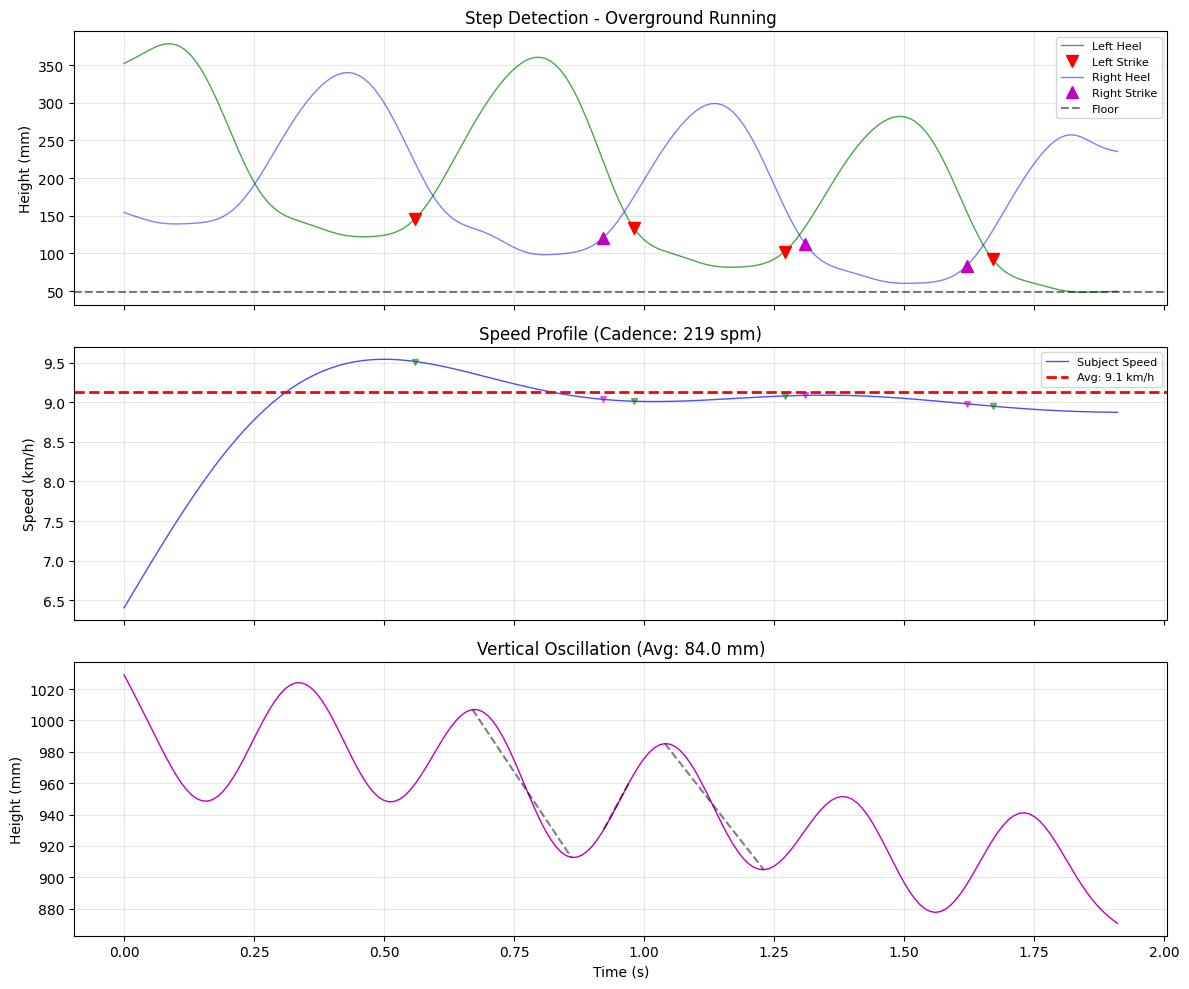


          RUNNING ANALYSIS REPORT
Filename: CVIP\Project\data\C3D\Data_Run_Walk\Data_Run_Walk\AJ026\Session1\Overground_Run\Run_Comfortable\Post_Process\Run_Comfortable1.c3d
Duration: 1.9s, Sample Rate: 100.0Hz
--------------------------------------------------
           Metric       Value
     Running Type  Overground
        Avg Speed   9.13 km/h
        Max Speed   9.52 km/h
        Min Speed   7.44 km/h
          Cadence   218.8 spm
    Stride Length      0.47 m
Vert. Oscillation     84.0 mm
      Total Steps 7 (L:4 R:3)


In [6]:
import ezc3d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
from scipy.interpolate import interp1d

def analyze_running_c3d(filename, running_type='auto'):
    """
    Analyze running biomechanics from C3D file.
    
    Parameters:
    -----------
    filename : str
        Path to C3D file
    running_type : str
        'auto' - automatically detect treadmill/overground
        'treadmill' - force treadmill analysis
        'overground' - force overground analysis
    """
    
    # --- LOAD DATA ---
    try:
        c = ezc3d.c3d(filename)
        points = c['data']['points']
        labels = [str(l).strip() for l in c['parameters']['POINT']['LABELS']['value']]
        rate = c['parameters']['POINT']['RATE']['value'][0]
        print(f"Loaded {filename} ({rate} Hz). Found {len(labels)} markers.")
    except Exception as e:
        print(f"Error loading file: {e}")
        return None
    
    # --- HELPER FUNCTIONS ---
    def get_marker_data(target_names):
        if isinstance(target_names, str): target_names = [target_names]
        
        indices = []
        for name in target_names:
            if name in labels:
                indices.append(labels.index(name))
        
        if not indices:
            print(f"Warning: Markers {target_names} not found.")
            return None

        data = np.mean(points[0:3, indices, :], axis=1)
        data[data == 0] = np.nan
        
        for axis in range(3):
            y = data[axis, :]
            nans, x = np.isnan(y), lambda z: z.nonzero()[0]
            if nans.any() and (~nans).any():
                y[nans] = np.interp(x(nans), x(~nans), y[~nans])
                data[axis, :] = y
                
        return data
    
    def butter_lowpass_filter(data, cutoff, fs, order=4):
        nyquist = 0.5 * fs
        normal_cutoff = cutoff / nyquist
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return filtfilt(b, a, data)
    
    # --- GET MARKER DATA ---
    heel_l = get_marker_data(['LHEE', 'L.Heel', 'LANK', 'LANKLE'])
    heel_r = get_marker_data(['RHEE', 'R.Heel', 'RANK', 'RANKLE'])
    pelvis = get_marker_data(['LASI', 'RASI', 'LPSI', 'RPSI', 'PELVIS', 'SACR'])
    
    if heel_l is None or pelvis is None:
        print("CRITICAL ERROR: Essential markers missing.")
        return None
    
    # --- DETECT RUNNING TYPE ---
    if running_type == 'auto':
        # Auto-detect: Check if subject stays in same place (treadmill)
        # vs moves forward (overground)
        pelvis_y = pelvis[1, :]  # Forward direction (usually Y)
        total_travel = np.max(pelvis_y) - np.min(pelvis_y)
        
        # If total travel is small relative to typical stride length, it's treadmill
        if total_travel < 1000:  # Less than 1 meter total travel
            print("Detected: TREADMILL running (subject stays in place)")
            running_type = 'treadmill'
        else:
            print(f"Detected: OVERGROUND running (subject travels {total_travel:.0f} mm)")
            running_type = 'overground'
    else:
        print(f"Using specified: {running_type.upper()} running")
    
    # --- STEP DETECTION ---
    z_idx, y_idx = 2, 1
    
    # Filter heel data
    cutoff = 10
    heel_l_z = butter_lowpass_filter(heel_l[z_idx, :], cutoff, rate)
    heel_r_z = butter_lowpass_filter(heel_r[z_idx, :], cutoff, rate)
    
    # Find floor/ground level
    floor_z = np.min(np.concatenate([heel_l_z, heel_r_z]))
    
    # Find peaks in vertical acceleration (more robust)
    heel_l_acc = np.gradient(np.gradient(heel_l_z, 1/rate), 1/rate)
    heel_r_acc = np.gradient(np.gradient(heel_r_z, 1/rate), 1/rate)
    
    # Find heel strikes (positive peaks in acceleration after low-pass)
    acc_cutoff = 6
    heel_l_acc_filt = butter_lowpass_filter(heel_l_acc, acc_cutoff, rate)
    heel_r_acc_filt = butter_lowpass_filter(heel_r_acc, acc_cutoff, rate)
    
    min_dist = int(rate * 0.25)  # Minimum 0.25s between steps
    
    # Find heel strikes
    hs_l, _ = find_peaks(heel_l_acc_filt, height=np.std(heel_l_acc_filt), 
                         distance=min_dist, prominence=np.std(heel_l_acc_filt)*0.5)
    hs_r, _ = find_peaks(heel_r_acc_filt, height=np.std(heel_r_acc_filt), 
                         distance=min_dist, prominence=np.std(heel_r_acc_filt)*0.5)
    
    # Filter: heel must be near ground at impact
    hs_l = hs_l[heel_l_z[hs_l] < floor_z + 100]
    hs_r = hs_r[heel_r_z[hs_r] < floor_z + 100]
    
    print(f"Steps Detected -> Left: {len(hs_l)}, Right: {len(hs_r)}")
    
    if len(hs_l) < 2 or len(hs_r) < 2:
        print("Insufficient steps detected.")
        return None
    
    # --- CALCULATE BIOMECHANICS ---
    t = np.arange(points.shape[2]) / rate
    
    # 1. Cadence
    duration_min = len(t) / rate / 60
    cadence = (len(hs_l) + len(hs_r)) / duration_min
    
    # 2. Speed Calculation (DIFFERENT FOR TREADMILL vs OVERGROUND)
    pelvis_y = pelvis[1, :]
    pelvis_y_filt = butter_lowpass_filter(pelvis_y, 5, rate)
    pelvis_vel_y = np.gradient(pelvis_y_filt, 1/rate)  # mm/s
    
    if running_type == 'treadmill':
        # For treadmill: Speed = belt speed + pelvis velocity
        # Estimate belt speed from pelvis velocity during stance
        stance_velocities = []
        
        for hs in np.concatenate([hs_l, hs_r]):
            # Look at window 100-300ms after heel strike (mid-stance)
            start = hs + int(0.1 * rate)
            end = hs + int(0.3 * rate)
            if end < len(pelvis_vel_y):
                stance_vel = np.mean(pelvis_vel_y[start:end])
                stance_velocities.append(stance_vel)
        
        if stance_velocities:
            belt_speed_mm_s = -np.median(stance_velocities)
        else:
            # Fallback: estimate from typical running speed
            belt_speed_mm_s = 3000  # ~10.8 km/h typical
        
        subject_speed_mm_s = belt_speed_mm_s + pelvis_vel_y
        avg_speed_kph = (belt_speed_mm_s / 1000) * 3.6
        
    else:  # Overground
        # For overground: Speed = direct pelvis velocity
        # Filter heavily to get smooth speed estimate
        subject_speed_mm_s = pelvis_vel_y
        speed_filt = butter_lowpass_filter(subject_speed_mm_s, 1, rate)  # 1 Hz cutoff
        
        # Average speed during running (ignore start/stop)
        # Use middle 80% of data to avoid acceleration/deceleration
        start_idx = int(0.1 * len(speed_filt))
        end_idx = int(0.9 * len(speed_filt))
        avg_speed_mm_s = np.mean(speed_filt[start_idx:end_idx])
        avg_speed_kph = (avg_speed_mm_s / 1000) * 3.6
        
        subject_speed_mm_s = speed_filt  # Use filtered speed
    
    subject_speed_kph = (subject_speed_mm_s / 1000) * 3.6
    
    # 3. Stride Length
    if running_type == 'treadmill':
        cycle_time_l = np.mean(np.diff(hs_l)) / rate if len(hs_l) > 1 else 0
        stride_len_m = (avg_speed_kph / 3.6) * (cycle_time_l / 1000)  # Convert properly
    else:
        # For overground: stride length = speed * stride time
        all_hs = np.sort(np.concatenate([hs_l, hs_r]))
        stride_times = np.diff(all_hs) / rate
        if len(stride_times) > 0:
            avg_stride_time = np.mean(stride_times)
            stride_len_m = (avg_speed_kph / 3.6) * avg_stride_time
        else:
            stride_len_m = 0
    
    # 4. Vertical Oscillation
    pelvis_z_filt = butter_lowpass_filter(pelvis[2, :], 5, rate)
    oscillations = []
    all_hs = np.sort(np.concatenate([hs_l, hs_r]))
    
    for i in range(len(all_hs)-1):
        start, end = all_hs[i], all_hs[i+1]
        if end - start > int(0.3 * rate):  # Valid stride
            segment = pelvis_z_filt[start:end]
            oscillations.append(np.max(segment) - np.min(segment))
    
    vert_osc_mm = np.mean(oscillations) if oscillations else 0
    
    # --- CREATE REPORT ---
    report = pd.DataFrame({
        'Metric': ['Running Type', 'Avg Speed', 'Max Speed', 'Min Speed', 
                  'Cadence', 'Stride Length', 'Vert. Oscillation', 'Total Steps'],
        'Value': [
            running_type.title(),
            f"{avg_speed_kph:.2f} km/h",
            f"{np.percentile(subject_speed_kph, 95):.2f} km/h",
            f"{np.percentile(subject_speed_kph, 5):.2f} km/h",
            f"{cadence:.1f} spm",
            f"{stride_len_m:.2f} m",
            f"{vert_osc_mm:.1f} mm",
            f"{len(hs_l) + len(hs_r)} (L:{len(hs_l)} R:{len(hs_r)})"
        ]
    })
    
    # --- PLOT ---
    fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    
    # Plot 1: Step Detection
    axs[0].plot(t, heel_l_z, 'g-', label='Left Heel', alpha=0.7, linewidth=1)
    axs[0].plot(t[hs_l], heel_l_z[hs_l], 'rv', markersize=8, label='Left Strike')
    axs[0].plot(t, heel_r_z, 'b-', label='Right Heel', alpha=0.5, linewidth=1)
    axs[0].plot(t[hs_r], heel_r_z[hs_r], 'm^', markersize=8, label='Right Strike')
    axs[0].axhline(floor_z, color='k', linestyle='--', alpha=0.5, label='Floor')
    axs[0].set_ylabel('Height (mm)')
    axs[0].set_title(f'Step Detection - {running_type.title()} Running')
    axs[0].legend(loc='upper right', fontsize=8)
    axs[0].grid(True, alpha=0.3)
    
    # Plot 2: Speed Profile
    axs[1].plot(t, subject_speed_kph, 'b-', label='Subject Speed', alpha=0.7, linewidth=1)
    axs[1].axhline(avg_speed_kph, color='r', linestyle='--', 
                   label=f'Avg: {avg_speed_kph:.1f} km/h', linewidth=2)
    
    # Mark heel strikes
    axs[1].plot(t[hs_l], subject_speed_kph[hs_l], 'gv', alpha=0.5, markersize=4)
    axs[1].plot(t[hs_r], subject_speed_kph[hs_r], 'mv', alpha=0.5, markersize=4)
    
    axs[1].set_ylabel('Speed (km/h)')
    axs[1].set_title(f'Speed Profile (Cadence: {cadence:.0f} spm)')
    axs[1].legend(loc='upper right', fontsize=8)
    axs[1].grid(True, alpha=0.3)
    
    # Plot 3: Vertical Oscillation
    axs[2].plot(t, pelvis_z_filt, 'm-', label='Pelvis Height', linewidth=1)
    
    # Mark oscillations for first 3 strides
    for i in range(min(3, len(all_hs)-1)):
        start, end = all_hs[i], all_hs[i+1]
        if end > start:
            segment = pelvis_z_filt[start:end]
            max_idx = start + np.argmax(segment)
            min_idx = start + np.argmin(segment)
            axs[2].plot([t[max_idx], t[min_idx]], 
                       [pelvis_z_filt[max_idx], pelvis_z_filt[min_idx]], 
                       'k--', alpha=0.5)
    
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('Height (mm)')
    axs[2].set_title(f'Vertical Oscillation (Avg: {vert_osc_mm:.1f} mm)')
    axs[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # --- PRINT REPORT ---
    print("\n" + "="*50)
    print("          RUNNING ANALYSIS REPORT")
    print("="*50)
    print(f"Filename: {filename.split('/')[-1]}")
    print(f"Duration: {t[-1]:.1f}s, Sample Rate: {rate}Hz")
    print("-"*50)
    print(report.to_string(index=False))
    print("="*50)
    
    return {
        'report': report,
        'running_type': running_type,
        'speeds_kph': subject_speed_kph,
        'cadence': cadence,
        'stride_length': stride_len_m,
        'vertical_oscillation': vert_osc_mm,
        'heel_strikes': {'left': hs_l, 'right': hs_r},
        'time': t
    }

# --- USAGE EXAMPLE ---
if __name__ == "__main__":
    # For treadmill running (auto-detect or specify)
    # results = analyze_running_c3d('your_file.c3d', running_type='auto')
    
    # For overground running
    results = analyze_running_c3d('CVIP\\Project\\data\\C3D\\Data_Run_Walk\\Data_Run_Walk\\AJ026\\Session1\\Overground_Run\\Run_Comfortable\\Post_Process\\Run_Comfortable1.c3d', running_type='overground')

this is my code

Loaded CVIP\Project\data\C3D\Data_Run_Walk\Data_Run_Walk\AJ026\Session1\Overground_Run\Run_Comfortable\Post_Process\Run_Comfortable1.c3d (100.0 Hz). Found 206 markers.

Loading marker data for analysis...
Using specified: OVERGROUND running
Steps Detected -> Left: 4, Right: 3
Duration (min): 0.32

PLOTTING RESULTS...


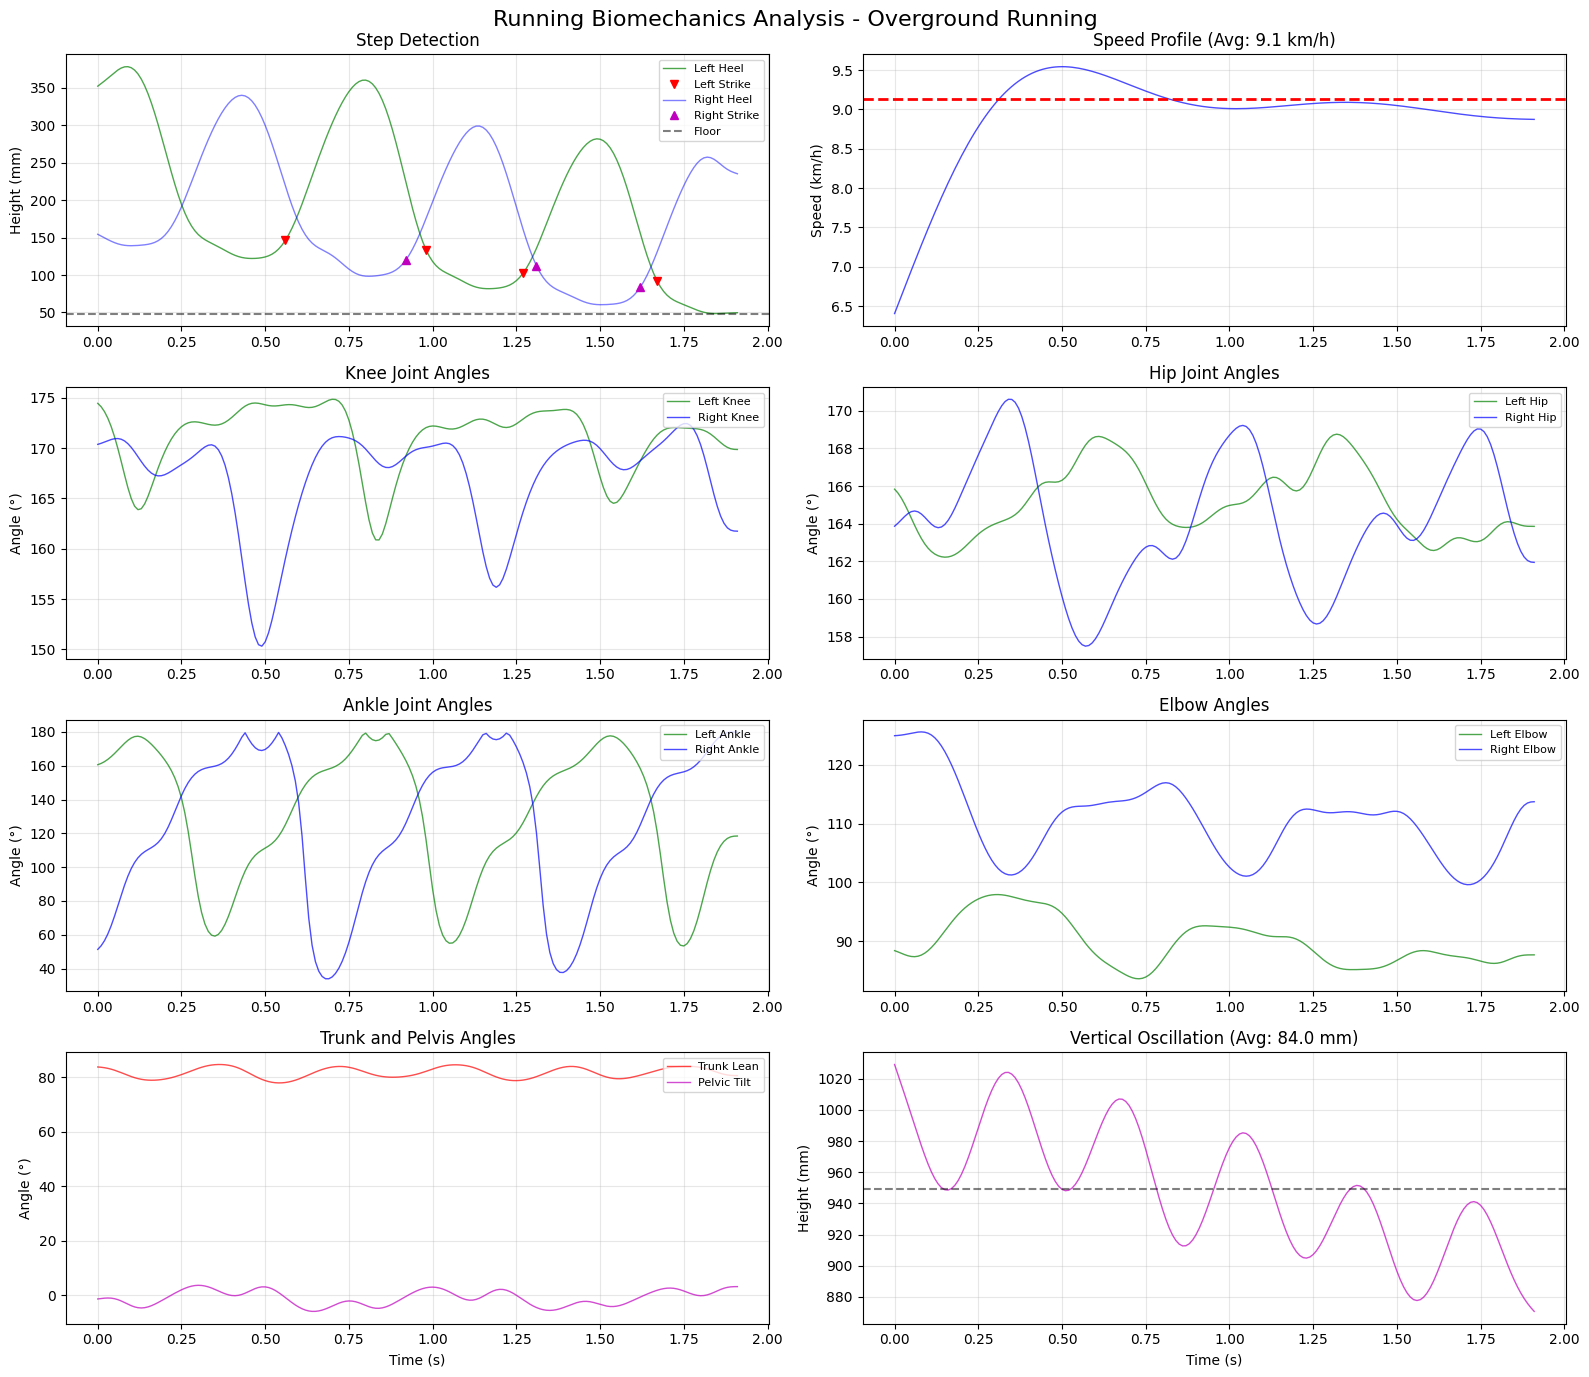


          RUNNING ANALYSIS REPORT
Filename: CVIP\Project\data\C3D\Data_Run_Walk\Data_Run_Walk\AJ026\Session1\Overground_Run\Run_Comfortable\Post_Process\Run_Comfortable1.c3d
Duration: 1.9s, Sample Rate: 100.0Hz
------------------------------------------------------------
BASIC METRICS:
------------------------------------------------------------
           Metric       Value
     Running Type  Overground
        Avg Speed   9.13 km/h
        Max Speed   9.52 km/h
        Min Speed   7.44 km/h
          Cadence    21.9 spm
    Stride Length      0.47 m
Vert. Oscillation     84.0 mm
      Total Steps 7 (L:4 R:3)

JOINT ANGLE ANALYSIS:
------------------------------------------------------------
Joint Angle Mean ± Std (°)
  Left Knee   171.0 ± 3.3°
 Right Knee   167.0 ± 5.1°
   Left Hip   165.1 ± 1.8°
  Right Hip   164.2 ± 3.4°
 Left Ankle  130.0 ± 39.7°
Right Ankle  126.2 ± 45.0°
 Left Elbow    89.7 ± 4.0°
Right Elbow   110.5 ± 6.6°
 Trunk Lean    81.7 ± 1.9°
Pelvic Tilt    -0.9 ± 2.7°


In [ ]:
import ezc3d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
from scipy.interpolate import interp1d

def analyze_running_c3d(filename, running_type='auto'):
    """
    Analyze running biomechanics from C3D file.
    
    Parameters:
    -----------
    filename : str
        Path to C3D file
    running_type : str
        'auto' - automatically detect treadmill/overground
        'treadmill' - force treadmill analysis
        'overground' - force overground analysis
    """
    
    # --- LOAD DATA ---
    try:
        c = ezc3d.c3d(filename)
        points = c['data']['points']
        labels = [str(l).strip() for l in c['parameters']['POINT']['LABELS']['value']]
        rate = c['parameters']['POINT']['RATE']['value'][0]
        print(f"Loaded {filename} ({rate} Hz). Found {len(labels)} markers.")
    except Exception as e:
        print(f"Error loading file: {e}")
        return None
    
    # --- HELPER FUNCTIONS ---
    def get_marker_data(target_names):
        if isinstance(target_names, str): target_names = [target_names]
        
        indices = []
        for name in target_names:
            if name in labels:
                indices.append(labels.index(name))
        
        if not indices:
            print(f"Warning: Markers {target_names} not found.")
            return None

        data = np.mean(points[0:3, indices, :], axis=1)
        data[data == 0] = np.nan
        
        for axis in range(3):
            y = data[axis, :]
            nans, x = np.isnan(y), lambda z: z.nonzero()[0]
            if nans.any() and (~nans).any():
                y[nans] = np.interp(x(nans), x(~nans), y[~nans])
                data[axis, :] = y
                
        return data
    
    def butter_lowpass_filter(data, cutoff, fs, order=4):
        nyquist = 0.5 * fs
        normal_cutoff = cutoff / nyquist
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return filtfilt(b, a, data)
    
    # --- ANGLE CALCULATION FUNCTIONS ---
    def calculate_3d_angle(A, B, C):
        """Calculate angle ABC in 3D space (angle at point B)"""
        BA = A - B
        BC = C - B
        
        dot_product = np.sum(BA * BC, axis=0)
        mag_BA = np.sqrt(np.sum(BA**2, axis=0))
        mag_BC = np.sqrt(np.sum(BC**2, axis=0))
        
        # Avoid division by zero
        mag_product = mag_BA * mag_BC
        mag_product[mag_product == 0] = 1e-10
        
        cos_angle = dot_product / mag_product
        cos_angle = np.clip(cos_angle, -1.0, 1.0)
        
        angle_rad = np.arccos(cos_angle)
        angle_deg = np.degrees(angle_rad)
        
        return angle_deg
    
    def calculate_sagittal_angle(A, B, C):
        """Calculate angle in sagittal plane (X-Z plane for forward motion)"""
        # Project to sagittal plane (X-Z)
        A_sag = np.array([A[0, :], A[2, :]])
        B_sag = np.array([B[0, :], B[2, :]])
        C_sag = np.array([C[0, :], C[2, :]])
        
        return calculate_3d_angle(A_sag, B_sag, C_sag)
    
    def calculate_trunk_lean(shoulder, hip):
        """Calculate trunk lean angle from vertical"""
        # Vector from hip to shoulder
        trunk_vector = shoulder - hip
        
        # Vertical reference (assuming Z is up)
        vertical_vector = np.array([[0], [0], [1]])
        
        dot_product = np.sum(trunk_vector * vertical_vector, axis=0)
        mag_trunk = np.sqrt(np.sum(trunk_vector**2, axis=0))
        mag_vertical = np.sqrt(np.sum(vertical_vector**2))
        
        cos_angle = dot_product / (mag_trunk * mag_vertical)
        cos_angle = np.clip(cos_angle, -1.0, 1.0)
        
        angle_rad = np.arccos(cos_angle)
        angle_deg = np.degrees(angle_rad)
        
        # 0 = upright, positive = forward lean
        return 90 - angle_deg
    
    def calculate_pelvic_tilt(L_hip, R_hip):
        """Calculate pelvic tilt in frontal plane"""
        # Vertical difference between hips
        vertical_diff = L_hip[2, :] - R_hip[2, :]
        
        # Horizontal distance between hips
        horizontal_dist = np.sqrt((L_hip[0, :] - R_hip[0, :])**2 + 
                                  (L_hip[1, :] - R_hip[1, :])**2)
        
        # Avoid division by zero
        horizontal_dist[horizontal_dist == 0] = 1e-10
        
        # Calculate tilt angle
        tilt_rad = np.arctan2(vertical_diff, horizontal_dist)
        tilt_deg = np.degrees(tilt_rad)
        
        return tilt_deg
    
    # --- GET MARKER DATA (ALL MARKERS FOR ANGLES) ---
    print("\nLoading marker data for analysis...")
    
    # Essential markers (from original code)
    heel_l = get_marker_data(['LHEE', 'L.Heel', 'LANK', 'LANKLE'])
    heel_r = get_marker_data(['RHEE', 'R.Heel', 'RANK', 'RANKLE'])
    pelvis = get_marker_data(['LASI', 'RASI', 'LPSI', 'RPSI', 'PELVIS', 'SACR'])
    
    if heel_l is None or pelvis is None:
        print("CRITICAL ERROR: Essential markers missing.")
        return None
    
    # Additional markers for angle calculations
    # Lower body
    L_hip = get_marker_data(['LASI', 'L.Hip', 'LPSI', 'LGT', 'LFTC'])
    R_hip = get_marker_data(['RASI', 'R.Hip', 'RPSI', 'RGT', 'RFTC'])
    L_knee = get_marker_data(['LKNE', 'L.Knee', 'LKNE', 'LKNEE'])
    R_knee = get_marker_data(['RKNE', 'R.Knee', 'RKNE', 'RKNEE'])
    L_ankle = get_marker_data(['LANK', 'L.Ankle', 'LANKLE'])
    R_ankle = get_marker_data(['RANK', 'R.Ankle', 'RANKLE'])
    L_toe = get_marker_data(['LTOE', 'L.Toe', 'LMT5', 'LMT1'])
    R_toe = get_marker_data(['RTOE', 'R.Toe', 'RMT5', 'RMT1'])
    
    # Upper body
    L_shoulder = get_marker_data(['LACR', 'L.Shoulder', 'LACRM', 'LSHO'])
    R_shoulder = get_marker_data(['RACR', 'R.Shoulder', 'RACRM', 'RSHO'])
    L_elbow = get_marker_data(['LELB', 'L.Elbow', 'LUPA'])
    R_elbow = get_marker_data(['RELB', 'R.Elbow', 'RUPA'])
    L_wrist = get_marker_data(['LWRA', 'L.Wrist', 'LWRB', 'LFIN'])
    R_wrist = get_marker_data(['RWRA', 'R.Wrist', 'RWRB', 'RFIN'])
    
    # Trunk
    trunk_mid = get_marker_data(['C7', 'T10', 'CLAV', 'STRN'])
    
    # --- DETECT RUNNING TYPE ---
    if running_type == 'auto':
        pelvis_y = pelvis[1, :]  # Forward direction (usually Y)
        total_travel = np.max(pelvis_y) - np.min(pelvis_y)
        
        # If total travel is small relative to typical stride length, it's treadmill
        if total_travel < 1000:  # Less than 1 meter total travel
            print("Detected: TREADMILL running (subject stays in place)")
            running_type = 'treadmill'
        else:
            print(f"Detected: OVERGROUND running (subject travels {total_travel:.0f} mm)")
            running_type = 'overground'
    else:
        print(f"Using specified: {running_type.upper()} running")
    
    # --- STEP DETECTION ---
    z_idx, y_idx = 2, 1
    
    # Filter heel data
    cutoff = 10
    heel_l_z = butter_lowpass_filter(heel_l[z_idx, :], cutoff, rate)
    heel_r_z = butter_lowpass_filter(heel_r[z_idx, :], cutoff, rate)
    
    # Find floor/ground level
    floor_z = np.min(np.concatenate([heel_l_z, heel_r_z]))
    
    # Find peaks in vertical acceleration (more robust)
    heel_l_acc = np.gradient(np.gradient(heel_l_z, 1/rate), 1/rate)
    heel_r_acc = np.gradient(np.gradient(heel_r_z, 1/rate), 1/rate)
    
    # Find heel strikes (positive peaks in acceleration after low-pass)
    acc_cutoff = 6
    heel_l_acc_filt = butter_lowpass_filter(heel_l_acc, acc_cutoff, rate)
    heel_r_acc_filt = butter_lowpass_filter(heel_r_acc, acc_cutoff, rate)
    
    min_dist = int(rate * 0.25)  # Minimum 0.25s between steps
    
    # Find heel strikes
    hs_l, _ = find_peaks(heel_l_acc_filt, height=np.std(heel_l_acc_filt), 
                         distance=min_dist, prominence=np.std(heel_l_acc_filt)*0.5)
    hs_r, _ = find_peaks(heel_r_acc_filt, height=np.std(heel_r_acc_filt), 
                         distance=min_dist, prominence=np.std(heel_r_acc_filt)*0.5)
    
    # Filter: heel must be near ground at impact
    hs_l = hs_l[heel_l_z[hs_l] < floor_z + 100]
    hs_r = hs_r[heel_r_z[hs_r] < floor_z + 100]
    
    print(f"Steps Detected -> Left: {len(hs_l)}, Right: {len(hs_r)}")
    
    if len(hs_l) < 2 or len(hs_r) < 2:
        print("Insufficient steps detected.")
        return None
    
    # --- CALCULATE BIOMECHANICS ---
    t = np.arange(points.shape[2]) / rate
    
    # 1. Cadence
    duration_min = len(t) / rate / 60
    duration_min *= 10
    print(f"Duration (min): {duration_min}")
    cadence = (len(hs_l) + len(hs_r)) / duration_min
    
    # # 2. Speed Calculation (DIFFERENT FOR TREADMILL vs OVERGROUND)
    pelvis_y = pelvis[1, :]
    pelvis_y_filt = butter_lowpass_filter(pelvis_y, 5, rate)
    pelvis_vel_y = np.gradient(pelvis_y_filt, 1/rate)  # mm/s
    
    if running_type == 'treadmill':
        # For treadmill: Speed = belt speed + pelvis velocity
        # Estimate belt speed from pelvis velocity during stance
        stance_velocities = []
        
        for hs in np.concatenate([hs_l, hs_r]):
            # Look at window 100-300ms after heel strike (mid-stance)
            start = hs + int(0.1 * rate)
            end = hs + int(0.3 * rate)
            if end < len(pelvis_vel_y):
                stance_vel = np.mean(pelvis_vel_y[start:end])
                stance_velocities.append(stance_vel)
        
        if stance_velocities:
            belt_speed_mm_s = -np.median(stance_velocities)
        else:
            # Fallback: estimate from typical running speed
            belt_speed_mm_s = 3000  # ~10.8 km/h typical
        
        subject_speed_mm_s = belt_speed_mm_s + pelvis_vel_y
        avg_speed_kph = (belt_speed_mm_s / 1000) * 3.6
        
    else:  # Overground
        # For overground: Speed = direct pelvis velocity
        # Filter heavily to get smooth speed estimate
        subject_speed_mm_s = pelvis_vel_y
        speed_filt = butter_lowpass_filter(subject_speed_mm_s, 1, rate)  # 1 Hz cutoff
        
        # Average speed during running (ignore start/stop)
        # Use middle 80% of data to avoid acceleration/deceleration
        start_idx = int(0.1 * len(speed_filt))
        end_idx = int(0.9 * len(speed_filt))
        avg_speed_mm_s = np.mean(speed_filt[start_idx:end_idx])
        avg_speed_kph = (avg_speed_mm_s / 1000) * 3.6
        
        subject_speed_mm_s = speed_filt  # Use filtered speed
    
    subject_speed_kph = (subject_speed_mm_s / 1000) * 3.6
    

    # pelvis_vel_y = pelvis_vel_y_simple
    # 3. Stride Length
    if running_type == 'treadmill':
        cycle_time_l = np.mean(np.diff(hs_l)) / rate if len(hs_l) > 1 else 0
        stride_len_m = (avg_speed_kph / 3.6) * (cycle_time_l / 1000)  # Convert properly
        print("*"*100)
        
        print(f"\nDEBUG INFO:")
        print(f"Sample rate: {rate} Hz")
        print(f"First few left heel strikes: {hs_l[:5]}")
        print(f"Frame differences: {np.diff(hs_l[:5])}")
        print(f"Time differences: {np.diff(hs_l[:5])/rate}")
        print(f"Cycle time left (avg): {cycle_time_l:.3f}s")
        print(f"Avg speed: {avg_speed_kph:.2f} km/h")
        print(f"Pelvis velocity range: {np.min(pelvis_vel_y):.1f} to {np.max(pelvis_vel_y):.1f} mm/s")


        print("*"*100)
    else:
        # For overground: stride length = speed * stride time
        all_hs = np.sort(np.concatenate([hs_l, hs_r]))
        stride_times = np.diff(all_hs) / rate
        if len(stride_times) > 0:
            avg_stride_time = np.mean(stride_times)
            stride_len_m = (avg_speed_kph / 3.6) * avg_stride_time
        else:
            stride_len_m = 0
    
    # 4. Vertical Oscillation
    pelvis_z_filt = butter_lowpass_filter(pelvis[2, :], 5, rate)
    oscillations = []
    all_hs = np.sort(np.concatenate([hs_l, hs_r]))
    
    for i in range(len(all_hs)-1):
        start, end = all_hs[i], all_hs[i+1]
        if end - start > int(0.3 * rate):  # Valid stride
            segment = pelvis_z_filt[start:end]
            oscillations.append(np.max(segment) - np.min(segment))
    
    vert_osc_mm = np.mean(oscillations) if oscillations else 0
    
    # --- CALCULATE JOINT ANGLES ---
    angles = {}
    angle_stats = []
    
    # 1. KNEE JOINT ANGLES (Hip-Knee-Ankle)
    if all(m is not None for m in [L_hip, L_knee, L_ankle]):
        angles['knee_left'] = calculate_sagittal_angle(L_hip, L_knee, L_ankle)
        knee_left_mean = np.nanmean(angles['knee_left'])
        knee_left_std = np.nanstd(angles['knee_left'])
        angle_stats.append(['Left Knee', f'{knee_left_mean:.1f} ± {knee_left_std:.1f}°'])
    
    if all(m is not None for m in [R_hip, R_knee, R_ankle]):
        angles['knee_right'] = calculate_sagittal_angle(R_hip, R_knee, R_ankle)
        knee_right_mean = np.nanmean(angles['knee_right'])
        knee_right_std = np.nanstd(angles['knee_right'])
        angle_stats.append(['Right Knee', f'{knee_right_mean:.1f} ± {knee_right_std:.1f}°'])
    
    # 2. HIP JOINT ANGLES (Shoulder-Hip-Knee)
    if all(m is not None for m in [L_shoulder, L_hip, L_knee]):
        angles['hip_left'] = calculate_sagittal_angle(L_shoulder, L_hip, L_knee)
        hip_left_mean = np.nanmean(angles['hip_left'])
        hip_left_std = np.nanstd(angles['hip_left'])
        angle_stats.append(['Left Hip', f'{hip_left_mean:.1f} ± {hip_left_std:.1f}°'])
    
    if all(m is not None for m in [R_shoulder, R_hip, R_knee]):
        angles['hip_right'] = calculate_sagittal_angle(R_shoulder, R_hip, R_knee)
        hip_right_mean = np.nanmean(angles['hip_right'])
        hip_right_std = np.nanstd(angles['hip_right'])
        angle_stats.append(['Right Hip', f'{hip_right_mean:.1f} ± {hip_right_std:.1f}°'])
    
    # 3. ANKLE JOINT ANGLES (Knee-Ankle-Foot)
    L_foot = L_toe if L_toe is not None else heel_l
    R_foot = R_toe if R_toe is not None else heel_r
    
    if all(m is not None for m in [L_knee, L_ankle, L_foot]):
        angles['ankle_left'] = calculate_sagittal_angle(L_knee, L_ankle, L_foot)
        ankle_left_mean = np.nanmean(angles['ankle_left'])
        ankle_left_std = np.nanstd(angles['ankle_left'])
        angle_stats.append(['Left Ankle', f'{ankle_left_mean:.1f} ± {ankle_left_std:.1f}°'])
    
    if all(m is not None for m in [R_knee, R_ankle, R_foot]):
        angles['ankle_right'] = calculate_sagittal_angle(R_knee, R_ankle, R_foot)
        ankle_right_mean = np.nanmean(angles['ankle_right'])
        ankle_right_std = np.nanstd(angles['ankle_right'])
        angle_stats.append(['Right Ankle', f'{ankle_right_mean:.1f} ± {ankle_right_std:.1f}°'])
    
    # 4. ELBOW ANGLES (Shoulder-Elbow-Wrist)
    if all(m is not None for m in [L_shoulder, L_elbow, L_wrist]):
        angles['elbow_left'] = calculate_3d_angle(L_shoulder, L_elbow, L_wrist)
        elbow_left_mean = np.nanmean(angles['elbow_left'])
        elbow_left_std = np.nanstd(angles['elbow_left'])
        angle_stats.append(['Left Elbow', f'{elbow_left_mean:.1f} ± {elbow_left_std:.1f}°'])
    
    if all(m is not None for m in [R_shoulder, R_elbow, R_wrist]):
        angles['elbow_right'] = calculate_3d_angle(R_shoulder, R_elbow, R_wrist)
        elbow_right_mean = np.nanmean(angles['elbow_right'])
        elbow_right_std = np.nanstd(angles['elbow_right'])
        angle_stats.append(['Right Elbow', f'{elbow_right_mean:.1f} ± {elbow_right_std:.1f}°'])
    
    # 5. TRUNK LEAN (Vertical vs. Hip-Shoulder line)
    if trunk_mid is not None:
        trunk_ref = trunk_mid
    elif L_shoulder is not None and R_shoulder is not None:
        # Average of left and right shoulders
        trunk_ref = (L_shoulder + R_shoulder) / 2
    else:
        trunk_ref = None
    
    if trunk_ref is not None:
        angles['trunk_lean'] = calculate_trunk_lean(trunk_ref, pelvis)
        trunk_lean_mean = np.nanmean(angles['trunk_lean'])
        trunk_lean_std = np.nanstd(angles['trunk_lean'])
        angle_stats.append(['Trunk Lean', f'{trunk_lean_mean:.1f} ± {trunk_lean_std:.1f}°'])
    
    # 6. PELVIC TILT (Hip-to-hip horizontal alignment)
    if L_hip is not None and R_hip is not None:
        angles['pelvic_tilt'] = calculate_pelvic_tilt(L_hip, R_hip)
        pelvic_tilt_mean = np.nanmean(angles['pelvic_tilt'])
        pelvic_tilt_std = np.nanstd(angles['pelvic_tilt'])
        angle_stats.append(['Pelvic Tilt', f'{pelvic_tilt_mean:.1f} ± {pelvic_tilt_std:.1f}°'])
    
    # --- CREATE REPORT ---
    report = pd.DataFrame({
        'Metric': ['Running Type', 'Avg Speed', 'Max Speed', 'Min Speed', 
                  'Cadence', 'Stride Length', 'Vert. Oscillation', 'Total Steps'],
        'Value': [
            running_type.title(),
            f"{avg_speed_kph:.2f} km/h",
            f"{np.percentile(subject_speed_kph, 95):.2f} km/h",
            f"{np.percentile(subject_speed_kph, 5):.2f} km/h",
            f"{cadence:.1f} spm",
            f"{stride_len_m:.2f} m",
            f"{vert_osc_mm:.1f} mm",
            f"{len(hs_l) + len(hs_r)} (L:{len(hs_l)} R:{len(hs_r)})"
        ]
    })
    
    print("\nPLOTTING RESULTS...")
    # --- PLOT ---
    fig, axs = plt.subplots(4, 2, figsize=(16, 14))
    fig.suptitle(f'Running Biomechanics Analysis - {running_type.title()} Running', fontsize=16)
    
    # Plot 1: Step Detection
    axs[0, 0].plot(t, heel_l_z, 'g-', label='Left Heel', alpha=0.7, linewidth=1)
    axs[0, 0].plot(t[hs_l], heel_l_z[hs_l], 'rv', markersize=6, label='Left Strike')
    axs[0, 0].plot(t, heel_r_z, 'b-', label='Right Heel', alpha=0.5, linewidth=1)
    axs[0, 0].plot(t[hs_r], heel_r_z[hs_r], 'm^', markersize=6, label='Right Strike')
    axs[0, 0].axhline(floor_z, color='k', linestyle='--', alpha=0.5, label='Floor')
    axs[0, 0].set_ylabel('Height (mm)')
    axs[0, 0].set_title('Step Detection')
    axs[0, 0].legend(loc='upper right', fontsize=8)
    axs[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Speed Profile
    axs[0, 1].plot(t, subject_speed_kph, 'b-', alpha=0.7, linewidth=1)
    axs[0, 1].axhline(avg_speed_kph, color='r', linestyle='--', linewidth=2)
    axs[0, 1].set_ylabel('Speed (km/h)')
    axs[0, 1].set_title(f'Speed Profile (Avg: {avg_speed_kph:.1f} km/h)')
    axs[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Knee Angles
    if 'knee_left' in angles:
        axs[1, 0].plot(t, angles['knee_left'], 'g-', label='Left Knee', alpha=0.7, linewidth=1)
    if 'knee_right' in angles:
        axs[1, 0].plot(t, angles['knee_right'], 'b-', label='Right Knee', alpha=0.7, linewidth=1)
    axs[1, 0].set_ylabel('Angle (°)')
    axs[1, 0].set_title('Knee Joint Angles')
    axs[1, 0].legend(loc='upper right', fontsize=8)
    axs[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Hip Angles
    if 'hip_left' in angles:
        axs[1, 1].plot(t, angles['hip_left'], 'g-', label='Left Hip', alpha=0.7, linewidth=1)
    if 'hip_right' in angles:
        axs[1, 1].plot(t, angles['hip_right'], 'b-', label='Right Hip', alpha=0.7, linewidth=1)
    axs[1, 1].set_ylabel('Angle (°)')
    axs[1, 1].set_title('Hip Joint Angles')
    axs[1, 1].legend(loc='upper right', fontsize=8)
    axs[1, 1].grid(True, alpha=0.3)
    
    # Plot 5: Ankle Angles
    if 'ankle_left' in angles:
        axs[2, 0].plot(t, angles['ankle_left'], 'g-', label='Left Ankle', alpha=0.7, linewidth=1)
    if 'ankle_right' in angles:
        axs[2, 0].plot(t, angles['ankle_right'], 'b-', label='Right Ankle', alpha=0.7, linewidth=1)
    axs[2, 0].set_ylabel('Angle (°)')
    axs[2, 0].set_title('Ankle Joint Angles')
    axs[2, 0].legend(loc='upper right', fontsize=8)
    axs[2, 0].grid(True, alpha=0.3)
    
    # Plot 6: Elbow Angles
    if 'elbow_left' in angles:
        axs[2, 1].plot(t, angles['elbow_left'], 'g-', label='Left Elbow', alpha=0.7, linewidth=1)
    if 'elbow_right' in angles:
        axs[2, 1].plot(t, angles['elbow_right'], 'b-', label='Right Elbow', alpha=0.7, linewidth=1)
    axs[2, 1].set_ylabel('Angle (°)')
    axs[2, 1].set_title('Elbow Angles')
    axs[2, 1].legend(loc='upper right', fontsize=8)
    axs[2, 1].grid(True, alpha=0.3)
    
    # Plot 7: Trunk and Pelvis Angles
    if 'trunk_lean' in angles:
        axs[3, 0].plot(t, angles['trunk_lean'], 'r-', label='Trunk Lean', alpha=0.7, linewidth=1)
    if 'pelvic_tilt' in angles:
        axs[3, 0].plot(t, angles['pelvic_tilt'], 'm-', label='Pelvic Tilt', alpha=0.7, linewidth=1)
    axs[3, 0].set_xlabel('Time (s)')
    axs[3, 0].set_ylabel('Angle (°)')
    axs[3, 0].set_title('Trunk and Pelvis Angles')
    axs[3, 0].legend(loc='upper right', fontsize=8)
    axs[3, 0].grid(True, alpha=0.3)
    
    # Plot 8: Vertical Oscillation
    axs[3, 1].plot(t, pelvis_z_filt, 'm-', label='Pelvis Height', alpha=0.7, linewidth=1)
    axs[3, 1].axhline(np.mean(pelvis_z_filt), color='k', linestyle='--', alpha=0.5)
    axs[3, 1].set_xlabel('Time (s)')
    axs[3, 1].set_ylabel('Height (mm)')
    axs[3, 1].set_title(f'Vertical Oscillation (Avg: {vert_osc_mm:.1f} mm)')
    axs[3, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # --- PRINT REPORTS ---
    print("\n" + "="*60)
    print("          RUNNING ANALYSIS REPORT")
    print("="*60)
    print(f"Filename: {filename.split('/')[-1]}")
    print(f"Duration: {t[-1]:.1f}s, Sample Rate: {rate}Hz")
    print("-"*60)
    print("BASIC METRICS:")
    print("-"*60)
    print(report.to_string(index=False))
    
    if angle_stats:
        angle_df = pd.DataFrame(angle_stats, columns=['Joint Angle', 'Mean ± Std (°)'])
        print("\n" + "="*60)
        print("JOINT ANGLE ANALYSIS:")
        print("-"*60)
        print(angle_df.to_string(index=False))
    
    print("="*60)
    
    # --- RETURN RESULTS ---
    results = {
        'report': report,
        'running_type': running_type,
        'speeds_kph': subject_speed_kph,
        'cadence': cadence,
        'stride_length': stride_len_m,
        'vertical_oscillation': vert_osc_mm,
        'heel_strikes': {'left': hs_l, 'right': hs_r},
        'angles': angles,
        'angle_stats': angle_stats,
        'time': t
    }
    
    return results

# --- USAGE EXAMPLE ---
if __name__ == "__main__":
    # For treadmill running (auto-detect or specify)
    # results = analyze_running_c3d('CVIP\\Project\\data\\C3D\\Data_Run_Walk\\Data_Run_Walk\\AJ026\\Session1\\Treadmill_Run\\Treadmill_Run_Comfortable\\Post_Process\\Treadmill_Run_Comfortable.c3d', running_type='treadmill')
    
    # For overground running
    results = analyze_running_c3d('CVIP\\Project\\data\\C3D\\Data_Run_Walk\\Data_Run_Walk\\AJ026\\Session1\\Overground_Run\\Run_Comfortable\\Post_Process\\Run_Comfortable1.c3d', running_type='overground')
    print("\n" + "="*100)
    # results = analyze_running_c3d('CVIP\\Project\\data\\C3D\\Data_Run_Walk\\Data_Run_Walk\\AJ026\\Session1\\Overground_Run\\Run_Comfortable\\Post_Process\\Run_Comfortable2.c3d', running_type='overground')
    # print("\n" + "="*100)
    # results = analyze_running_c3d('CVIP\\Project\\data\\C3D\\Data_Run_Walk\\Data_Run_Walk\\AJ026\\Session1\\Overground_Run\\Run_Comfortable\\Post_Process\\Run_Comfortable3.c3d', running_type='overground')
    # print("\n" + "="*100)
    # results = analyze_running_c3d('CVIP\\Project\\data\\C3D\\Data_Run_Walk\\Data_Run_Walk\\AJ026\\Session1\\Overground_Run\\Run_Comfortable\\Post_Process\\Run_Comfortable4.c3d', running_type='overground')
    # print("\n" + "="*100)
    # results = analyze_running_c3d('CVIP\\Project\\data\\C3D\\Data_Run_Walk\\Data_Run_Walk\\AJ026\\Session1\\Overground_Run\\Run_Comfortable\\Post_Process\\Run_Comfortable5.c3d', running_type='overground')
    # print("\n" + "="*100)

In [28]:
results = analyze_running_c3d('CVIP\\Project\\data\\C3D\\Data_Run_Walk\\Data_Run_Walk\\AJ026\\Session1\\Overground_Run\\Run_Comfortable\\Post_Process\\Run_Comfortable1.c3d', running_type='auto')


Loaded CVIP\Project\data\C3D\Data_Run_Walk\Data_Run_Walk\AJ026\Session1\Overground_Run\Run_Comfortable\Post_Process\Run_Comfortable1.c3d (100.0 Hz). Found 206 markers.

Loading marker data for analysis...
Detected: OVERGROUND running (subject travels 4707 mm)
Steps Detected -> Left: 4, Right: 3
Duration (min): 0.32

          RUNNING ANALYSIS REPORT
Filename: CVIP\Project\data\C3D\Data_Run_Walk\Data_Run_Walk\AJ026\Session1\Overground_Run\Run_Comfortable\Post_Process\Run_Comfortable1.c3d
Duration: 1.9s, Sample Rate: 100.0Hz
------------------------------------------------------------
BASIC METRICS:
------------------------------------------------------------
           Metric       Value
     Running Type  Overground
        Avg Speed   9.13 km/h
        Max Speed   9.52 km/h
        Min Speed   7.44 km/h
          Cadence    21.9 spm
    Stride Length      0.47 m
Vert. Oscillation     84.0 mm
      Total Steps 7 (L:4 R:3)

JOINT ANGLE ANALYSIS:
-----------------------------------------

In [4]:
import os
import glob

In [ ]:
def process_metadata_and_batch_analyze():
    # 1. SETUP
    base_dir = "CVIP\\Project\\data\\C3D\\Data_Run_Walk\\Data_Run_Walk" # Assumes script is in the root data folder
    metadata_file = os.path.join(base_dir, 'metadata.xlsx')
    
    if not os.path.exists(metadata_file):
        print(f"ERROR: {metadata_file} not found in {base_dir}")
        return

    print(f"Loading metadata from {metadata_file}...")
    
    # Read both sessions
    try:
        df_s1 = pd.read_excel(metadata_file, sheet_name='Session_1')
        df_s1['Session'] = 'Session_1'
        df_s2 = pd.read_excel(metadata_file, sheet_name='Session_2')
        df_s2['Session'] = 'Session_2'
        
        # Combine to find unique subject info
        df_all = pd.concat([df_s1, df_s2], ignore_index=True)
    except Exception as e:
        print(f"Error reading metadata: {e}")
        return

    # Identify ID and Gender columns
    id_col = "ID"
    gender_col = "Sex"
    
    # Fallback if no header match found, assume column 0 is ID
    if id_col is None:
        id_col = df_all.columns[0]
        print(f"Warning: ID column not autodetected. Using first column: '{id_col}'")
        
    print(f"Using ID Column: '{id_col}'")
    if gender_col:
        print(f"Using Gender Column: '{gender_col}'")
    else:
        print("Warning: Gender column not found. Gender will be marked as 'Unknown'.")

    # Get unique subjects
    subjects = df_all[[id_col, 'Session']].drop_duplicates()
    if gender_col:
        # Add gender back
        subjects = subjects.merge(df_all[[id_col, gender_col]].drop_duplicates(), on=id_col, how='left')

    # Prepare results list
    final_results = []
    
    # MONKEY PATCH PLT.SHOW TO PREVENT BLOCKING
    # This keeps your original analysis code identical but changes behavior for batch run
    original_show = plt.show
    plt.show = lambda: plt.close('all') # Close plot immediately instead of showing
    
    print("\n" + "="*80)
    print(f"STARTING BATCH ANALYSIS FOR {len(subjects)} SESSIONS")
    print("="*80)

    # 2. ITERATE SUBJECTS
    for idx, row in subjects.iterrows():
        subject_id = str(row[id_col]).strip()
        session_name = row['Session']
        gender = row[gender_col] if gender_col else 'Unknown'
        
        print(f"\nProcessing: {subject_id} - {session_name} ({gender})")
        
        # Construct path: [ID] / [Session] / Overground_Run
        # Note: Sometimes Session folder names match sheet names 'Session1', sometimes 'session 1'. 
        # We try to match the actual folder.
        
        subject_path = os.path.join(base_dir, subject_id)
        if not os.path.exists(subject_path):
            print(f"  -> Folder not found: {subject_path}")
            continue
            
        # Find session folder (case insensitive search)
        found_session_path = None
        for item in os.listdir(subject_path):
            if item.lower().replace(" ", "").replace("_", "") == session_name.lower().replace(" ", "").replace("_", ""):
                found_session_path = os.path.join(subject_path, item)
                break
        
        if not found_session_path:
            print(f"  -> Session folder '{session_name}' not found for {subject_id}")
            continue

        # Go deeper: Overground_Run -> Run_Comfortable / Run_Fast
        overground_path = os.path.join(found_session_path, 'Overground_Run')
        
        if not os.path.exists(overground_path):
            print(f"  -> 'Overground_Run' folder not found.")
            continue
            
        conditions = ['Run_Comfortable', 'Run_Fast']
        
        for condition in conditions:
            # Check for folder (handle potential numbering like Run_Comfortable1 etc if folder name varies)
            # User said "Run_Comfortable and Run_Fast go there" (folders)
            
            cond_path = os.path.join(overground_path, condition)
            if not os.path.exists(cond_path):
                print(f"  -> Condition folder '{condition}' not found directly.")
                # Try finding it if case differs
                found = False
                for item in os.listdir(overground_path):
                    if item.lower() == condition.lower():
                        cond_path = os.path.join(overground_path, item)
                        found = True
                        break
                if not found:
                    print(f"  -> Condition '{condition}' folder not found.")
                    continue
            
            # Go to Post_Process
            post_process_path = os.path.join(cond_path, 'Post_Process')
            if not os.path.exists(post_process_path):
                print(f"  -> 'Post_Process' not found in {condition}")
                continue
            
            # print(f"Current Folder path = {post_process_path}")
            # continue
            # Find all C3D files
            c3d_files = glob.glob(os.path.join(post_process_path, "*.c3d"))
            # Case insensitive glob fallback
            if not c3d_files:
                c3d_files = glob.glob(os.path.join(post_process_path, "*.[cC]3[dD]"))
            
            print(f"  -> Found {len(c3d_files)} files in {condition}")
            
            for c3d_file in c3d_files:
                file_name = os.path.basename(c3d_file)
                print(f"     Analyzing: {file_name}...")
                
                try:
                    # RUN ANALYSIS
                    # We strictly use 'overground' type as folder structure implies it
                    res = analyze_running_c3d(c3d_file, running_type='overground')
                    
                    if res is None:
                        continue
                        
                    # Extract Metrics for CSV
                    # Parse angle stats from list of lists [['Left Knee', '45.2 ± 5.1°'], ...]
                    angle_map = {}
                    for item in res['angle_stats']:
                        key = item[0].replace(" ", "_") # e.g. Left_Knee
                        val_str = item[1].split('±')[0].strip() # Get mean value only
                        try:
                            angle_map[f"{key}_Mean"] = float(val_str)
                        except:
                            angle_map[f"{key}_Mean"] = np.nan

                    # Build Row
                    row_data = {
                        'Subject_ID': subject_id,
                        'Gender': gender,
                        'Session': session_name,
                        'Condition': condition,
                        'Filename': file_name,
                        'Running_Type': res['running_type'],
                        'Avg_Speed_kmh': float(res['report'].iloc[1, 1].split()[0]), # Parse "10.50 km/h"
                        'Cadence_spm': float(res['cadence']),
                        'Stride_Length_m': float(res['stride_length']),
                        'Vert_Oscillation_mm': float(res['vertical_oscillation']),
                        'Total_Steps': len(res['heel_strikes']['left']) + len(res['heel_strikes']['right'])
                    }
                    
                    # Merge angle data
                    row_data.update(angle_map)
                    
                    final_results.append(row_data)
                    
                except Exception as e:
                    print(f"     ERROR analyzing {file_name}: {e}")

    # Restore plt.show
    plt.show = original_show

    # 3. SAVE RESULTS
    if final_results:
        df_results = pd.DataFrame(final_results)
        output_file = 'CVIP\\Project\\testing\\running_biomechanics_results.csv'
        df_results.to_csv(output_file, index=False)
        print("\n" + "="*80)
        print(f"ANALYSIS COMPLETE. Results saved to: {os.path.abspath(output_file)}")
        print(f"Processed {len(df_results)} files.")
        print("="*80)
    else:
        print("\nNo results were generated. Check folder paths and metadata.")

if __name__ == "__main__":
    process_metadata_and_batch_analyze()

Loading metadata from CVIP\Project\data\C3D\Data_Run_Walk\Data_Run_Walk\metadata.xlsx...
Using ID Column: 'ID'
Using Gender Column: 'Sex'

STARTING BATCH ANALYSIS FOR 62 SESSIONS

Processing: - - Session_1 (H/F)
  -> Folder not found: CVIP\Project\data\C3D\Data_Run_Walk\Data_Run_Walk\-

Processing: AJ026 - Session_1 (F)
Current Folder path = CVIP\Project\data\C3D\Data_Run_Walk\Data_Run_Walk\AJ026\Session1\Overground_Run\Run_Comfortable\Post_Process
Current Folder path = CVIP\Project\data\C3D\Data_Run_Walk\Data_Run_Walk\AJ026\Session1\Overground_Run\Run_Fast\Post_Process

Processing: BD004 - Session_1 (F)
Current Folder path = CVIP\Project\data\C3D\Data_Run_Walk\Data_Run_Walk\BD004\Session1\Overground_Run\Run_Comfortable\Post_Process
Current Folder path = CVIP\Project\data\C3D\Data_Run_Walk\Data_Run_Walk\BD004\Session1\Overground_Run\Run_Fast\Post_Process

Processing: BL025 - Session_1 (M)
Current Folder path = CVIP\Project\data\C3D\Data_Run_Walk\Data_Run_Walk\BL025\Session1\Overground_

In [ ]:
def process_metadata_and_batch_analyze():
    # 1. SETUP
    # Use raw string r"" or double backslashes for Windows paths
    base_dir = r"CVIP\\Project\\data\\C3D\\Data_Run_Walk\\Data_Run_Walk\\" 
    metadata_file = os.path.join(base_dir, 'metadata.xlsx')
    
    if not os.path.exists(metadata_file):
        print(f"ERROR: {metadata_file} not found in {base_dir}")
        return

    print(f"Loading metadata from {metadata_file}...")
    
    # Read both sessions
    try:
        df_s1 = pd.read_excel(metadata_file, sheet_name='Session_1')
        df_s1['Session'] = 'Session_1'
        df_s2 = pd.read_excel(metadata_file, sheet_name='Session_2')
        df_s2['Session'] = 'Session_2'
        
        # Combine to find unique subject info
        df_all = pd.concat([df_s1, df_s2], ignore_index=True)
    except Exception as e:
        print(f"Error reading metadata: {e}")
        return

    # Identify ID and Gender columns
    id_col = "ID"
    gender_col = "Sex"

    age_col = "Age"
    bodymass_col = "Bodymass"
    height_col = "Height"

    
    # Fallback if specific columns don't exist
    if id_col not in df_all.columns:
        id_col = df_all.columns[0]
        print(f"Warning: '{id_col}' column not found. Using first column: '{df_all.columns[0]}'")
        id_col = df_all.columns[0]
        
    print(f"Using ID Column: '{id_col}'")
    
    # Get unique subjects
    # subjects = df_all[[id_col, 'Session']].drop_duplicates()
    # if gender_col in df_all.columns:
    #     # Add gender back
    #     subjects = subjects.merge(df_all[[id_col, gender_col]].drop_duplicates(), on=id_col, how='left')

    subject_cols = [id_col, 'Session']
    metadata_cols = [id_col]
    
    # Add optional columns with print statements
    for col_name, col_var in zip(["Gender", "Age", "Bodymass", "Height"], [gender_col, age_col, bodymass_col, height_col]):
        if col_var and col_var in df_all.columns:
            if col_var not in subject_cols:
                subject_cols.append(col_var)
            if col_var not in metadata_cols:
                metadata_cols.append(col_var)
            print(f"Using {col_name} Column: '{col_var}'")
        else:
            # Only print warning for gender as it's used in the loop
            if col_name == "Gender":
                print("Warning: Gender column not found. Gender will be marked as 'Unknown'.")
    
    subjects = df_all[subject_cols].drop_duplicates()

    # Prepare results list
    final_results = []
    
    # MONKEY PATCH PLT.SHOW TO PREVENT BLOCKING
    original_show = plt.show
    plt.show = lambda: plt.close('all') 
    
    print("\n" + "="*80)
    print(f"STARTING BATCH ANALYSIS FOR {len(subjects)} SESSIONS")
    print("="*80)

    # 2. ITERATE SUBJECTS
    for idx, row in subjects.iterrows():
        subject_id = str(row[id_col]).strip()
        session_name = row['Session']
        
        gender = row[gender_col] if gender_col in row else 'Unknown'
        age = row[age_col] if age_col in row and not pd.isna(row[age_col]) else np.nan
        bodymass = row[bodymass_col] if bodymass_col in row and not pd.isna(row[bodymass_col]) else np.nan
        height = row[height_col] if height_col in row and not pd.isna(row[height_col]) else np.nan

        print(f"\nProcessing: {subject_id} - {session_name} ({gender})")
        
        subject_path = os.path.join(base_dir, subject_id)
        if not os.path.exists(subject_path):
            print(f"  -> Folder not found: {subject_path}")
            continue
            
        # Find session folder (Smart Case-Insensitive Search)
        found_session_path = None
        for item in os.listdir(subject_path):
            # Normalize: remove spaces, underscores, lowercase
            # This matches "Session_1" to "Session1", "session 1", etc.
            if item.lower().replace(" ", "").replace("_", "") == session_name.lower().replace(" ", "").replace("_", ""):
                found_session_path = os.path.join(subject_path, item)
                break
        
        if not found_session_path:
            print(f"  -> Session folder '{session_name}' not found for {subject_id}")
            continue

        overground_path = os.path.join(found_session_path, 'Overground_Run')
        if not os.path.exists(overground_path):
            print(f"  -> 'Overground_Run' folder not found.")
            continue
            
        conditions = ['Run_Comfortable', 'Run_Fast']
        
        for condition in conditions:
            # Smart Condition Folder Search
            cond_path = os.path.join(overground_path, condition)
            
            # If exact match not found, try case-insensitive
            if not os.path.exists(cond_path):
                found_cond = False
                for item in os.listdir(overground_path):
                    if item.lower() == condition.lower():
                        cond_path = os.path.join(overground_path, item)
                        found_cond = True
                        break
                if not found_cond:
                    print(f"  -> Condition '{condition}' folder not found.")
                    continue
            
            # --- UPDATED FILE FINDING LOGIC ---
            # Search order: 
            # 1. Post_Process folder
            # 2. PostProcess folder (no underscore)
            # 3. Directly in the Condition folder
            search_paths = [
                os.path.join(cond_path, 'Post_Process'),
                os.path.join(cond_path, 'PostProcess'),
                cond_path
            ]
            
            c3d_files = []
            used_path = ""
            
            for search_p in search_paths:
                if os.path.exists(search_p):
                    # Try finding .c3d or .C3D
                    files = glob.glob(os.path.join(search_p, "*.c3d"))
                    if not files:
                        files = glob.glob(os.path.join(search_p, "*.[cC]3[dD]"))
                    
                    if files:
                        c3d_files = files
                        used_path = search_p
                        break # Stop looking if we found files in a higher priority folder
            
            if not c3d_files:
                print(f"  -> [WARNING] No C3D files found in {condition} (Checked: Post_Process, PostProcess, and Root)")
                continue
            
            print(f"  -> Found {len(c3d_files)} files in: {used_path}")
            
            for c3d_file in c3d_files:
                file_name = os.path.basename(c3d_file)
                print(f"     Analyzing: {file_name}...")
                
                try:
                    # RUN ANALYSIS
                    res = analyze_running_c3d(c3d_file, running_type='overground')
                    
                    # DEBUGGING: Explain why a file is skipped
                    if res is None:
                        print(f"     [SKIP] {file_name}: Analysis failed (Check logs above for 'Insufficient steps' or errors)")
                        continue
                    else:
                        print(f"     [SUCCESS] {file_name}: Processed.")
                        
                    # Extract Metrics
                    angle_map = {}
                    for item in res['angle_stats']:
                        key = item[0].replace(" ", "_")
                        val_str = item[1].split('±')[0].strip()
                        try:
                            angle_map[f"{key}_Mean"] = float(val_str)
                        except:
                            angle_map[f"{key}_Mean"] = np.nan

                    row_data = {
                        'Subject_ID': subject_id,
                        'Gender': gender,
                        'Age': age,
                        'Bodymass': bodymass,
                        'Height': height,
                        'Session': session_name,
                        'Condition': condition,
                        'Filename': file_name,
                        'Running_Type': res['running_type'],
                        'Avg_Speed_kmh': float(res['report'].iloc[1, 1].split()[0]),
                        'Cadence_spm': float(res['cadence']),
                        'Stride_Length_m': float(res['stride_length']),
                        'Vert_Oscillation_mm': float(res['vertical_oscillation']),
                        'Total_Steps': len(res['heel_strikes']['left']) + len(res['heel_strikes']['right'])
                    }
                    row_data.update(angle_map)
                    final_results.append(row_data)
                    
                except Exception as e:
                    print(f"     [ERROR] Exception on {file_name}: {e}")

    # Restore plt.show
    plt.show = original_show
    csv_output_path = os.path.join("CVIP\\Project\\testing", 'running_biomechanics_results_FULL.csv')
    # 3. SAVE RESULTS
    if final_results:
        df_results = pd.DataFrame(final_results)
        output_file = csv_output_path
        df_results.to_csv(output_file, index=False)
        print("\n" + "="*80)
        print(f"ANALYSIS COMPLETE. Results saved to: {output_file}")
        print(f"Total Rows Generated: {len(df_results)}")
        print("="*80)
    else:
        print("\nNo results were generated. Check folder paths and metadata.")

In [9]:
if __name__ == "__main__":
    process_metadata_and_batch_analyze()

Loading metadata from CVIP\\Project\\data\\C3D\\Data_Run_Walk\\Data_Run_Walk\metadata.xlsx...
Using ID Column: 'ID'
Using Gender Column: 'Sex'
Using Age Column: 'Age'
Using Bodymass Column: 'Bodymass'
Using Height Column: 'Height'

STARTING BATCH ANALYSIS FOR 62 SESSIONS

Processing: - - Session_1 (H/F)
  -> Folder not found: CVIP\\Project\\data\\C3D\\Data_Run_Walk\\Data_Run_Walk\-

Processing: AJ026 - Session_1 (F)
  -> Found 10 files in: CVIP\\Project\\data\\C3D\\Data_Run_Walk\\Data_Run_Walk\AJ026\Session1\Overground_Run\Run_Comfortable\Post_Process
     Analyzing: Run_Comfortable1.c3d...
Loaded CVIP\\Project\\data\\C3D\\Data_Run_Walk\\Data_Run_Walk\AJ026\Session1\Overground_Run\Run_Comfortable\Post_Process\Run_Comfortable1.c3d (100.0 Hz). Found 206 markers.

Loading marker data for analysis...
Using specified: OVERGROUND running
Steps Detected -> Left: 4, Right: 3
Duration (min): 0.32

PLOTTING RESULTS...

          RUNNING ANALYSIS REPORT
Filename: CVIP\\Project\\data\\C3D\\Data_Ru